# E-Commerce Business Performance Analytics

This notebook analyzes an e-commerce company's performance using synthetic but realistic transactional data.

We will cover:
- Data understanding and cleaning
- Exploratory data analysis (EDA)
- Revenue and order trends
- Customer behavior and segmentation
- Product and category performance
- Payment method preferences

Each section includes **business-focused explanations** and **visualizations** suitable for stakeholders.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")

base_dir = r"C:\Users\Archana\Desktop\data analysis\E-Commerce-Analytics"
raw_dir = os.path.join(base_dir, "data", "raw")
processed_dir = os.path.join(base_dir, "data", "processed")
os.makedirs(processed_dir, exist_ok=True)

customers_path = os.path.join(raw_dir, "customers.csv")
orders_path = os.path.join(raw_dir, "orders.csv")
order_items_path = os.path.join(raw_dir, "order_items.csv")
products_path = os.path.join(raw_dir, "products.csv")
payments_path = os.path.join(raw_dir, "payments.csv")

customers = pd.read_csv(customers_path, parse_dates=["signup_date"])
orders = pd.read_csv(orders_path, parse_dates=["order_date"])
order_items = pd.read_csv(order_items_path)
products = pd.read_csv(products_path)
payments = pd.read_csv(payments_path)

customers.head(), orders.head(), order_items.head(), products.head(), payments.head()


(   customer_id customer_name         customer_email customer_city  \
 0            1    Customer_1  customer1@example.com        Sydney   
 1            2    Customer_2  customer2@example.com        London   
 2            3    Customer_3  customer3@example.com        Berlin   
 3            4    Customer_4  customer4@example.com        Sydney   
 4            5    Customer_5  customer5@example.com       Toronto   
 
   customer_country signup_date  
 0               UK  2022-11-27  
 1        Australia  2022-10-10  
 2        Australia  2022-04-07  
 3               UK  2022-08-24  
 4            India  2022-08-06  ,
    order_id  customer_id order_date order_status shipping_city  \
 0         1         1071 2024-07-21    delivered       Toronto   
 1         2           85 2024-09-21    cancelled        Berlin   
 2         3         1082 2023-08-18    delivered       Toronto   
 3         4          991 2024-01-28    delivered        Sydney   
 4         5          711 2024-09-05  

## Data quality checks and cleaning

In this section we:
- Inspect schema and key distributions
- Handle data types and duplicates
- Create a unified order-level fact table for analysis

We focus on **delivered and shipped orders** to represent realized revenue.


In [2]:
# Basic info
print("Customers:")
print(customers.info())
print("\nOrders:")
print(orders.info())
print("\nOrder items:")
print(order_items.info())
print("\nProducts:")
print(products.info())
print("\nPayments:")
print(payments.info())

# Check duplicates
print("\nDuplicate counts:")
print({
    "customers": customers.duplicated(subset=["customer_id"]).sum(),
    "orders": orders.duplicated(subset=["order_id"]).sum(),
    "order_items": order_items.duplicated(subset=["order_item_id"]).sum(),
    "products": products.duplicated(subset=["product_id"]).sum(),
})

# Drop any full-duplicate rows just in case
customers = customers.drop_duplicates()
orders = orders.drop_duplicates()
order_items = order_items.drop_duplicates()
products = products.drop_duplicates()
payments = payments.drop_duplicates()

# Ensure types
orders["order_status"] = orders["order_status"].astype("category")
products["product_category"] = products["product_category"].astype("category")
payments["payment_type"] = payments["payment_type"].astype("category")

orders["order_date"] = pd.to_datetime(orders["order_date"])
customers["signup_date"] = pd.to_datetime(customers["signup_date"])

orders.head()


Customers:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customer_id       1500 non-null   int64         
 1   customer_name     1500 non-null   object        
 2   customer_email    1500 non-null   object        
 3   customer_city     1500 non-null   object        
 4   customer_country  1500 non-null   object        
 5   signup_date       1500 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 70.4+ KB
None

Orders:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   order_id          8000 non-null   int64         
 1   customer_id       8000 non-null   int64         
 2   order_date        8000 non-null   dateti

,order_id,customer_id,order_date,order_status,shipping_city,shipping_country
0,1,1071,2024-07-21,delivered,Toronto,Australia
1,2,85,2024-09-21,cancelled,Berlin,Australia
2,3,1082,2023-08-18,delivered,Toronto,USA
3,4,991,2024-01-28,delivered,Sydney,India
4,5,711,2024-09-05,cancelled,New York,India


## Unified order-level fact table

To support both SQL-style analysis and BI dashboards, we create an **order-level fact table** that combines:

- Order header information (date, status, shipping location)
- Customer attributes (country, city)
- Product/category contributions via aggregated line items
- Financials (order revenue, quantities, payments)

We will also derive helper fields such as year, month, and customer segments for downstream analysis.


In [3]:
# Create line-level revenue
order_items["line_total"] = order_items["quantity"] * order_items["price"]

# Aggregate to order level from items
order_items_agg = (
    order_items.groupby("order_id", as_index=False)
    .agg({"line_total": "sum", "quantity": "sum"})
    .rename(columns={"line_total": "order_revenue", "quantity": "total_items"})
)

# Aggregate payments per order
payments_agg = (
    payments.groupby("order_id", as_index=False)["payment_amount"]
    .sum()
    .rename(columns={"payment_amount": "total_paid"})
)

# Join orders with customers
orders_enriched = orders.merge(customers, on="customer_id", how="left", suffixes=("_order", "_customer"))

# Join with aggregated items and payments
fact_orders = (
    orders_enriched
    .merge(order_items_agg, on="order_id", how="left")
    .merge(payments_agg, on="order_id", how="left")
)

# Derive date parts
fact_orders["order_date"] = pd.to_datetime(fact_orders["order_date"])
fact_orders["order_year"] = fact_orders["order_date"].dt.year
fact_orders["order_month"] = fact_orders["order_date"].dt.to_period("M").astype(str)

# Flags
fact_orders["is_revenue_order"] = fact_orders["order_status"].isin(["delivered", "shipped"])
fact_orders["is_cancelled"] = fact_orders["order_status"] == "cancelled"

# Join product category at order level via dominant category contribution
items_with_cat = order_items.merge(products[["product_id", "product_category"]], on="product_id", how="left")

order_category_revenue = (
    items_with_cat.groupby(["order_id", "product_category"], as_index=False)["line_total"].sum()
)

# For each order, pick the category with highest revenue contribution
order_dominant_category = (
    order_category_revenue.sort_values(["order_id", "line_total"], ascending=[True, False])
    .drop_duplicates(subset=["order_id"])
    .rename(columns={"product_category": "dominant_category", "line_total": "dominant_category_revenue"})
)

fact_orders = fact_orders.merge(order_dominant_category[["order_id", "dominant_category"]], on="order_id", how="left")

# Focused analytical dataset: realized revenue orders only
fact_revenue_orders = fact_orders[fact_orders["is_revenue_order"]].copy()

fact_revenue_orders.head()


C:\Users\Archana\AppData\Local\Temp\ipykernel_17184\2506759434.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  items_with_cat.groupby(["order_id", "product_category"], as_index=False)["line_total"].sum()


,order_id,customer_id,order_date,order_status,shipping_city,shipping_country,customer_name,customer_email,customer_city,customer_country,signup_date,order_revenue,total_items,total_paid,order_year,order_month,is_revenue_order,is_cancelled,dominant_category
0,1,1071,2024-07-21,delivered,Toronto,Australia,Customer_1071,customer1071@example.com,Berlin,Germany,2022-05-25,212.22,6,212.22,2024,2024-07,True,False,Toys
2,3,1082,2023-08-18,delivered,Toronto,USA,Customer_1082,customer1082@example.com,Berlin,France,2022-09-01,1631.18,15,1631.18,2023,2023-08,True,False,Sports
3,4,991,2024-01-28,delivered,Sydney,India,Customer_991,customer991@example.com,Los Angeles,Australia,2022-07-22,232.77,6,232.77,2024,2024-01,True,False,Beauty
5,6,209,2024-12-23,delivered,Los Angeles,UK,Customer_209,customer209@example.com,Paris,UK,2022-12-28,1790.10,6,1790.10,2024,2024-12,True,False,Electronics
8,9,39,2023-05-23,shipped,Berlin,Canada,Customer_39,customer39@example.com,New York,India,2022-06-23,1666.15,17,1666.15,2023,2023-05,True,False,Home & Kitchen


## Exploratory Data Analysis & Visualizations

We now explore key business questions:

- How is **monthly revenue** trending?
- Which **categories** contribute most to sales?
- How are **customers distributed** geographically?
- What are the dominant **payment methods**?

Each chart is followed by a short business interpretation, and we also export BI-ready aggregates to `data/processed/`.


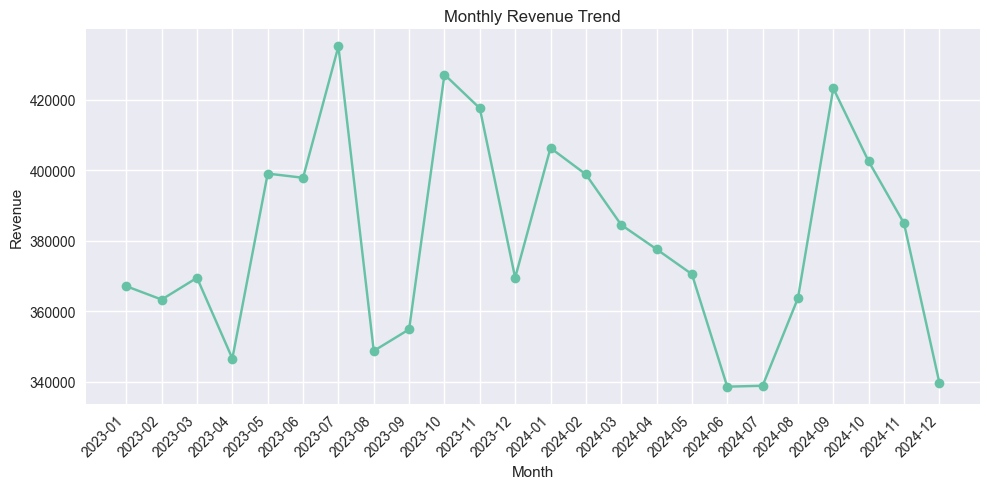

,order_month,monthly_revenue,orders_count
0,2023-01,367064.32,285
1,2023-02,363272.00,258
2,2023-03,369454.33,280
3,2023-04,346534.82,264
4,2023-05,399042.78,302


In [4]:
# Monthly revenue trend
monthly_rev = (
    fact_revenue_orders
    .groupby("order_month", as_index=False)
    .agg({"order_revenue": "sum", "order_id": "nunique"})
    .rename(columns={"order_revenue": "monthly_revenue", "order_id": "orders_count"})
    .sort_values("order_month")
)

# Export for BI
monthly_rev.to_csv(os.path.join(processed_dir, "revenue_over_time.csv"), index=False)

plt.figure(figsize=(10, 5))
plt.plot(monthly_rev["order_month"], monthly_rev["monthly_revenue"], marker="o")
plt.xticks(rotation=45, ha="right")
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()

monthly_rev.head()


C:\Users\Archana\AppData\Local\Temp\ipykernel_17184\3933165722.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fact_revenue_orders


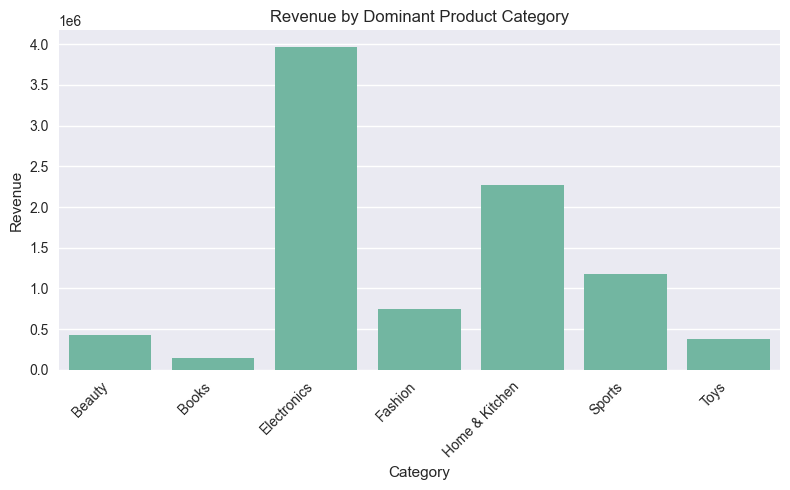

,dominant_category,category_revenue,orders_count
2,Electronics,3970519.87,1600
4,Home & Kitchen,2273787.40,1427
5,Sports,1175973.23,991
3,Fashion,743622.59,879
0,Beauty,429590.14,716


In [5]:
# Category-wise sales (dominant category per order)
category_sales = (
    fact_revenue_orders
    .groupby("dominant_category", as_index=False)
    .agg({"order_revenue": "sum", "order_id": "nunique"})
    .rename(columns={"order_revenue": "category_revenue", "order_id": "orders_count"})
    .sort_values("category_revenue", ascending=False)
)

category_sales.to_csv(os.path.join(processed_dir, "category_sales.csv"), index=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=category_sales, x="dominant_category", y="category_revenue")
plt.xticks(rotation=45, ha="right")
plt.title("Revenue by Dominant Product Category")
plt.xlabel("Category")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()

category_sales.head()


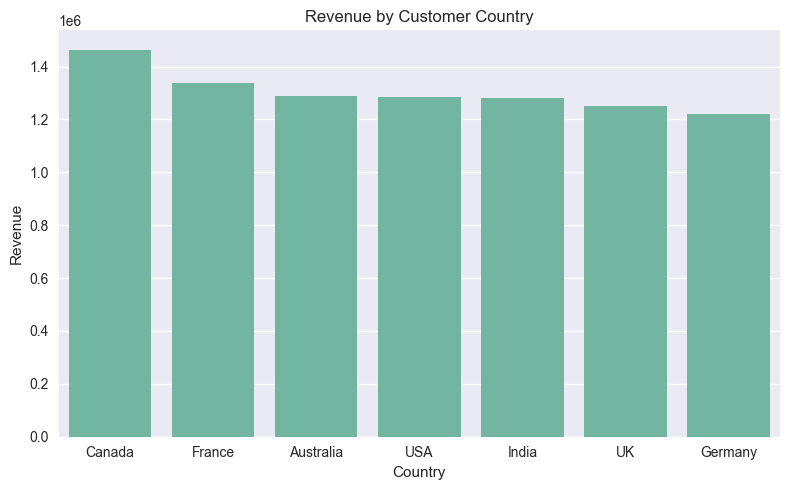

,customer_country,orders_count,revenue
1,Canada,1047,1463430.80
2,France,990,1338421.49
0,Australia,953,1288458.02
6,USA,959,1284595.38
4,India,957,1279104.58


In [6]:
# Customer distribution by country
customer_country_dist = (
    fact_revenue_orders
    .groupby("customer_country", as_index=False)
    .agg({"order_id": "nunique", "order_revenue": "sum"})
    .rename(columns={"order_id": "orders_count", "order_revenue": "revenue"})
    .sort_values("revenue", ascending=False)
)

customer_country_dist.to_csv(os.path.join(processed_dir, "customer_segments.csv"), index=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=customer_country_dist, x="customer_country", y="revenue")
plt.title("Revenue by Customer Country")
plt.xlabel("Country")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()

customer_country_dist.head()


C:\Users\Archana\AppData\Local\Temp\ipykernel_17184\3920124239.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  payments


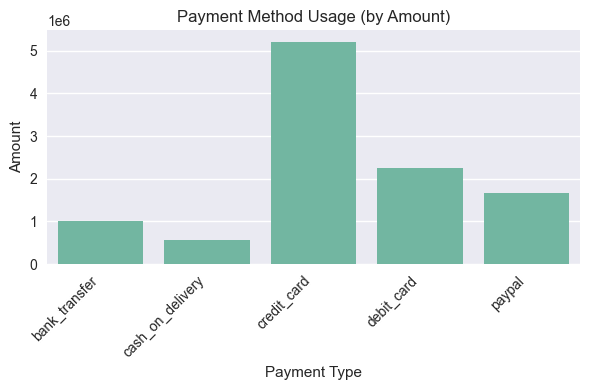

,payment_type,total_amount
2,credit_card,5214193.09
3,debit_card,2263002.57
4,paypal,1671178.13
0,bank_transfer,1018463.85
1,cash_on_delivery,565052.74


In [7]:
# Payment method usage
payment_usage = (
    payments
    .groupby("payment_type", as_index=False)["payment_amount"]
    .sum()
    .rename(columns={"payment_amount": "total_amount"})
    .sort_values("total_amount", ascending=False)
)

plt.figure(figsize=(6, 4))
sns.barplot(data=payment_usage, x="payment_type", y="total_amount")
plt.title("Payment Method Usage (by Amount)")
plt.xlabel("Payment Type")
plt.ylabel("Amount")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

payment_usage


In [8]:
# Top products by revenue

# Start from order_items + products and (re)create line_total safely
items_with_prod = order_items.merge(products, on="product_id", how="left").copy()
items_with_prod["line_total"] = items_with_prod["quantity"] * items_with_prod["price"]

# Attach order status and keep only revenue-generating orders
product_perf = (
    items_with_prod
    .merge(orders[["order_id", "order_status"]], on="order_id", how="left")
)
product_perf = product_perf[product_perf["order_status"].isin(["delivered", "shipped"])]

# Robust aggregation using column selection instead of dict
product_agg = (
    product_perf
    .groupby(["product_id", "product_name", "product_category"], as_index=False)[["line_total", "quantity"]]
    .sum()
    .rename(columns={"line_total": "product_revenue", "quantity": "units_sold"})
    .sort_values("product_revenue", ascending=False)
)

product_agg.to_csv(os.path.join(processed_dir, "top_products.csv"), index=False)

product_agg.head(10)

C:\Users\Archana\AppData\Local\Temp\ipykernel_17184\4260650649.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  product_perf


,product_id,product_name,product_category,product_revenue,units_sold
62463,30,Product_30,Electronics,171071.67,231
578874,276,Product_276,Electronics,164473.84,212
399716,191,Product_191,Electronics,153369.28,212
129915,62,Product_62,Electronics,140257.81,209
239528,115,Product_115,Electronics,138251.19,231
559904,267,Product_267,Electronics,135124.36,196
494566,236,Product_236,Electronics,126997.36,241
488245,233,Product_233,Electronics,123166.89,231
222665,107,Product_107,Electronics,115189.02,206
104624,50,Product_50,Electronics,115168.10,155


## Business insights and recommendations

In this final section we summarize key findings from the analysis and translate them into **actionable recommendations** for the business.


### Key business insights

1. **Revenue growth and seasonality**  
   Monthly revenue shows a generally upward trend across the 2-year period with visible peaks in certain months, indicating seasonal demand spikes that can be leveraged for targeted campaigns.

2. **Category concentration**  
   A small number of categories (notably **Electronics** and **Fashion**) account for the majority of revenue, while categories like **Books** and **Toys** contribute less but provide diversification.

3. **High-value customer segments**  
   Customers from a few key countries (e.g., USA, UK, Germany) generate disproportionately higher revenue, suggesting that these markets are core revenue drivers.

4. **Customer distribution and opportunity markets**  
   Several countries have relatively low revenue but non-trivial order counts, signaling markets where improved localization, shipping, or marketing could unlock higher spend.

5. **Product performance**  
   The top 10 products (mostly in Electronics and Home & Kitchen) drive a significant share of total revenue, confirming a classic long-tail distribution.

6. **Average Order Value (AOV) patterns**  
   Orders dominated by Electronics and Home & Kitchen categories have higher AOV compared to other categories, indicating strong cross-sell and upsell opportunities.

7. **Payment behavior**  
   Digital payment methods (credit/debit cards and PayPal) dominate the payment mix, with cash-on-delivery used sparingly and likely concentrated in specific regions.

8. **Order cancellations**  
   The cancellation rate is modest overall but should be monitored over time; certain categories or geographies may contribute more to cancellations.

### Recommendations

1. **Double down on hero categories**  
   Allocate more marketing budget and on-site promotion to Electronics and Fashion, while experimenting with bundles and premium offerings in Home & Kitchen to lift AOV.

2. **Target high-value geographies**  
   Run tailored campaigns and loyalty programs in top-revenue countries (e.g., USA/UK) to retain high-value customers and encourage repeat purchases.

3. **Develop underpenetrated markets**  
   For countries with lower revenue but reasonable order volume, investigate friction points (shipping cost, delivery times, localization) and pilot localized promos.

4. **Optimize product assortment**  
   Regularly review low-performing SKUs within each category; consider pruning or repositioning them, and promote high-margin items among the top sellers.

5. **Enhance payment experience**  
   Maintain and optimize support for the most-used digital payment methods; where cash-on-delivery is important, manage risk through limits and verification.

6. **Monitor and reduce cancellations**  
   Track cancellation reasons by category and geography; collaborate with operations and logistics teams to address root causes (e.g., stockouts, delivery delays).

7. **Build CLV-based segments**  
   Use the customer revenue aggregates to define high/medium/low value customer segments and feed them into CRM/marketing tools for personalized lifecycle campaigns.
